In [1]:
from copy import deepcopy

import matplotlib.pyplot as plt
import tqdm as notebook_tqdm

from gnn import GNN
from data import get_loaders, process_qm9, Z_ONE_HOT_DIM, EDGE_ATTR_DIM
from supervised import train_supervised
from vicreg import VICReg, train_vicreg

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

c:\Users\Tadija\miniconda3\envs\ssl\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
train_loader, val_loader, test_loader = get_loaders(data_dir='./QM9', type='supervised',
                                                    batch_size=512)

gnn_hidden_dims = 64
gnn_num_blocks = 2

model = GNN(
    n_hidden=gnn_hidden_dims,
    num_convolution_blocks=gnn_num_blocks,
    supervised=True,
    n_output=1,
).to(device)

model_frozen = deepcopy(model).to(device)

for param in model_frozen.conv_blocks.parameters():
    param.requires_grad = False

model_frozen.embedding.weight.requires_grad = False
model_frozen.embedding.bias.requires_grad = False

Starting epoch 0
Batch 0 loss: 0.3326057195663452
Batch 100 loss: 0.32430315017700195
Val loss at end of epoch: 0.35753887295722964
Starting epoch 1
Batch 0 loss: 0.300581693649292
Batch 100 loss: 0.37059423327445984
Val loss at end of epoch: 0.35518658459186553
Starting epoch 2
Batch 0 loss: 0.28015047311782837
Batch 100 loss: 0.3786306381225586
Val loss at end of epoch: 0.35402042120695115
Starting epoch 3
Batch 0 loss: 0.40303003787994385
Batch 100 loss: 0.36542463302612305
Val loss at end of epoch: 0.3557352140545845
Starting epoch 4
Batch 0 loss: 0.32420456409454346
Batch 100 loss: 0.3782026767730713
Val loss at end of epoch: 0.3537451960146427
Starting epoch 5
Batch 0 loss: 0.3473816514015198
Batch 100 loss: 0.3265203833580017
Val loss at end of epoch: 0.3496468305587769
Starting epoch 6
Batch 0 loss: 0.29690128564834595
Batch 100 loss: 0.2727692127227783
Val loss at end of epoch: 0.34770879819989203
Starting epoch 7
Batch 0 loss: 0.31036728620529175
Batch 100 loss: 0.34492516517

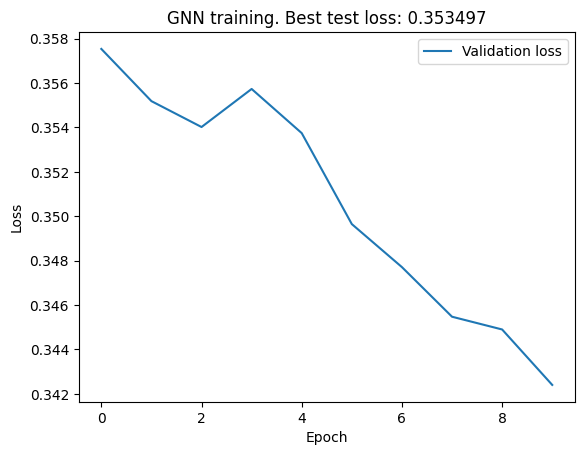

In [11]:
# Run supervised training on target 7

# model.to(device)
# model, test_loss, val_losses, logging_info = train_supervised(
#     train_loader, val_loader, test_loader, model, 
#     lr=0.001, epochs=10, label_index=7, device=device
# )

# plt.plot(val_losses, label='Validation loss')
# plt.xlabel("Epoch")
# plt.ylabel("Loss")

# plt.title('{0} training. Best test loss: {1:4f}'.format('GNN', test_loss))
# plt.legend()

# plt.show()

model_frozen, f_test_loss, f_val_losses, logging_info = train_supervised(
    train_loader, val_loader, test_loader, model_frozen,
    lr=0.001, epochs=10, label_index=7, device=device, log_every_n_batches=100
)

plt.plot(f_val_losses, label='Validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.title('{0} training. Best test loss: {1:4f}'.format('GNN', f_test_loss))
plt.legend()

In [4]:
vicreg = VICReg(
    siamese=True,
    n_hidden=64,
    num_convolution_blocks=2,
    exp_coeff=3,
    global_inv_coeff=25,
    std_coeff=25,
    cov_coeff=1
).to(device)

In [5]:
loader, _loader, _ = get_loaders(data_dir='./QM9', type='vicreg', batch_size=4096)
optimizer = torch.optim.Adam(vicreg.parameters(), lr=0.001, amsgrad=True)
epochs = 100

train_vicreg(vicreg, loader, _loader, optimizer, epochs, log_every_n_batches=40)
torch.save(vicreg.state_dict(), 'vicreg.pt')

Starting epoch 0
Batch 0 loss: 76.70809173583984
Starting epoch 1
Batch 0 loss: 34.15437316894531
Starting epoch 2
Batch 0 loss: 29.353260040283203
Starting epoch 3
Batch 0 loss: 25.825498580932617
Starting epoch 4
Batch 0 loss: 24.01732635498047
Starting epoch 5
Batch 0 loss: 21.335472106933594
Starting epoch 6
Batch 0 loss: 20.011592864990234
Starting epoch 7
Batch 0 loss: 18.410377502441406
Starting epoch 8
Batch 0 loss: 15.767163276672363
Starting epoch 9
Batch 0 loss: 15.778100967407227
Starting epoch 10
Batch 0 loss: 14.737958908081055
Starting epoch 11
Batch 0 loss: 12.791873931884766
Starting epoch 12
Batch 0 loss: 12.901074409484863
Starting epoch 13
Batch 0 loss: 14.179792404174805
Starting epoch 14
Batch 0 loss: 9.168420791625977
Starting epoch 15
Batch 0 loss: 9.368535995483398
Starting epoch 16
Batch 0 loss: 8.21426010131836
Starting epoch 17
Batch 0 loss: 7.834621429443359
Starting epoch 18
Batch 0 loss: 7.620558738708496
Starting epoch 19
Batch 0 loss: 7.017796516418457


KeyboardInterrupt: 

In [14]:
# load if needed
# vicreg.load_state_dict(torch.load('vicreg.pt'))

<All keys matched successfully>

Starting epoch 0
Batch 0 loss: 0.8325057625770569
Batch 100 loss: 0.3895688056945801
Val loss at end of epoch: 0.35366381108760836
Starting epoch 1
Batch 0 loss: 0.37833690643310547
Batch 100 loss: 0.308967262506485
Val loss at end of epoch: 0.3420744612812996
Starting epoch 2
Batch 0 loss: 0.3625701069831848
Batch 100 loss: 0.5085932016372681
Val loss at end of epoch: 0.33458508886396887
Starting epoch 3
Batch 0 loss: 0.2731686234474182
Batch 100 loss: 0.3805769979953766
Val loss at end of epoch: 0.3212956771254539
Starting epoch 4
Batch 0 loss: 0.3155311048030853
Batch 100 loss: 0.3651922941207886
Val loss at end of epoch: 0.31689045391976833
Starting epoch 5
Batch 0 loss: 0.31938889622688293
Batch 100 loss: 0.30568063259124756
Val loss at end of epoch: 0.2941607631742954
Starting epoch 6
Batch 0 loss: 0.2792798578739166
Batch 100 loss: 0.2811594009399414
Val loss at end of epoch: 0.26841120310127736
Starting epoch 7
Batch 0 loss: 0.26624155044555664
Batch 100 loss: 0.258792906999588

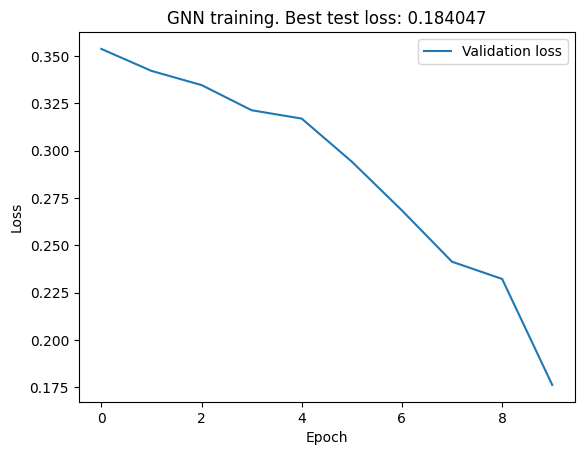

In [12]:
encoder = deepcopy(vicreg.encoder)
encoder.to(device)
encoder.supervised = True

# optimizer = torch.optim.Adam([
#     {'params': encoder.conv_blocks.parameters(), 'lr': 0.0001},
#     {'params': encoder.embedding.parameters(), 'lr': 0.0001},
#     ], lr=0.001)



encoder, test_loss, val_losses, logging_info = train_supervised(
    train_loader, val_loader, test_loader, encoder, 
    lr=0.001, epochs=10, label_index=7, optimizer=None, device=device, log_every_n_batches=100
)

plt.plot(val_losses, label='Validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.title('{0} training. Best test loss: {1:4f}'.format('GNN', test_loss))
plt.legend()

plt.show()


Starting epoch 0
Batch 0 loss: 0.993456244468689
Batch 100 loss: 0.3696228861808777
Val loss at end of epoch: 0.38638175949454306
Starting epoch 1
Batch 0 loss: 0.3713073432445526
Batch 100 loss: 0.32366251945495605
Val loss at end of epoch: 0.36722539365291595
Starting epoch 2
Batch 0 loss: 0.3680962920188904
Batch 100 loss: 0.3387835919857025
Val loss at end of epoch: 0.3567675858736038
Starting epoch 3
Batch 0 loss: 0.35688143968582153
Batch 100 loss: 0.3356185853481293
Val loss at end of epoch: 0.3503659412264824
Starting epoch 4
Batch 0 loss: 0.28073811531066895
Batch 100 loss: 0.466455340385437
Val loss at end of epoch: 0.3458925873041153
Starting epoch 5
Batch 0 loss: 0.2833898067474365
Batch 100 loss: 0.28855377435684204
Val loss at end of epoch: 0.33844522200524807
Starting epoch 6
Batch 0 loss: 0.5581341981887817
Batch 100 loss: 0.2714289426803589
Val loss at end of epoch: 0.33372039496898653
Starting epoch 7
Batch 0 loss: 0.3270323872566223
Batch 100 loss: 0.3078757524490356

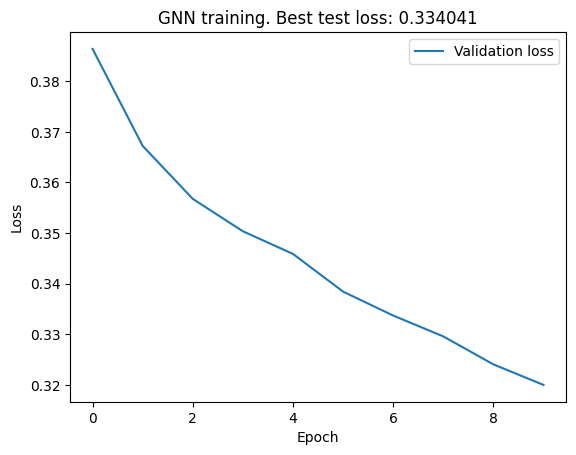

In [7]:
encoder = deepcopy(vicreg.encoder)
encoder.to(device)
encoder.supervised = True

# freeze gnn params, set encoder to supervised

for param in encoder.conv_blocks.parameters():
    param.requires_grad = False

encoder.embedding.weight.requires_grad = False
encoder.embedding.bias.requires_grad = False

encoder, test_loss, val_losses, logging_info = train_supervised(
    train_loader, val_loader, test_loader, encoder, 
    lr=0.001, epochs=10, label_index=7, device=device, log_every_n_batches=100
)

plt.plot(val_losses, label='Validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.title('{0} training. Best test loss: {1:4f}'.format('GNN', test_loss))
plt.legend()

plt.show()
